# Prova 2 - NLP - 2025s1

INSTRUÇÕES: Resolva esta prova. Após, transcreva as partes dissertativas das respostas para o Blackboard (CTRL-C / CTRL-V) nos espaços indicados. Por fim, anexe seu notebook como material complementar da Questão 2.

## Rubrica geral da prova

Níveis de aprendizado

* 0 [F] Insuficiente: Falha em atingir todos os requisitos do nível seguinte.
* 2.5 [D] Em desenvolvimento: Identifica o sub-domínio ou a categoria de ferramentas que podem levar a soluções de problemas. Identifica quais são as entradas e saídas de um sistema, e seu significado para o problema. É capaz de resolver problemas usando códigos "template".
* 5.0 [C] Básico: É capaz de argumentar a favor ou contra uma solução usando jargões técnicos, com uso mínimo de metáforas. Usa corretamente métricas de desempenho para avaliar soluções. É capaz de modificar parâmetros de sistema para adequá-los a uma situação específica e avaliar o efeito dessas modificações.
* 7.5 [B] Proficiente: Identifica, usando método científico, os componentes do sistema que levam a gargalos de desempenho. Argumenta corretamente e usando os jargões adequados sobre as limitações das métricas de desempenho, e argumenta sobre o impacto dessas limitações para o problema específico. Cita brevemente formulações matemáticas. Justifica suas principais escolhas com argumentos precisos e/ou com resultados de análises.
* 10 [A] Avançado: Argumenta sobre soluções e sobre suas limitações usando jargões técnicos precisos. Liga claramente os parâmetros do mundo real aos parâmetros matemáticos das formulações. Justifica todas as suas escolhas com argumentos precisos e/ou com resultados de análises.

## Problema

É relativamente comum usarmos embeddings gerados pelo BERT para classificar frases. Em geral, o código para gerar embeddings com BERT se parece com:

```python
    from transformers import BertTokenizer, BertModel
    from tqdm import tqdm
    import numpy as np
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    def get_embeddings(text, model, tokenizer):
        # Tokenize the input text
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[0, 0, :]
        return cls_embedding

    embeddings = []
    for i in tqdm(range(len(X))):
        e = get_embeddings(X.iloc[i], model, tokenizer)
        embeddings.append(e.detach().numpy())
    embeddings = np.array(embeddings)
    np.save('bert_embeddings.npy', embeddings)
```

De acordo com o [artigo do BERT](https://arxiv.org/abs/1810.04805), os embeddings foram treinados, usando um token por palavra, em diversos textos em inglês:

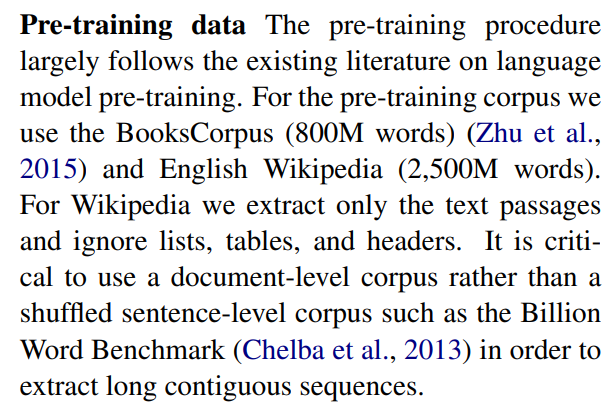

Porém, em lugares que não temos a língua inglesa como língua padrão, gostaríamos de realizar tarefas de classificação em línguas nativas.

Neste trabalho, vamos trabalhar com a classificação de mensagens no twitter sobre o Ibovespa. A ideia de fazer essa classificação é que o Twitter poderia ser uma representação do sentimento geral do mercado (*bullish* ou *bearish* markets). O dataset para isso é o seguinte:

In [3]:
import kagglehub
from pathlib import Path
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("jvbeltra/sentiment-analysis-pt-br-stock-market-tweets")
path = Path(path)
df = pd.read_csv(path / "analise_sentimentos_ibovespa_twitter.csv")
df.head()

,post_id,text,created_at,finbertptbr_prediction,gpt_prediction,real_sentiment
0,1818246570069934451,"a partir desse cálculo, para cada empresa do i...",2024-07-30T08:25:38.000000Z,NEUTRAL,NEUTRAL,NEUTRAL
1,1818251106570395982,ibovespa reage às entrelinhas do relatório de ...,2024-07-30T08:43:39.000000Z,NEUTRAL,NEUTRAL,NEUTRAL
2,1818257465793765640,ibovespa em queda de olho na reunião do copom,2024-07-30T09:08:56.000000Z,NEGATIVE,NEGATIVE,NEGATIVE
3,1818262436144669087,esquenta dos mercados \nbom dia!\no ibovespa a...,2024-07-30T09:28:41.000000Z,POSITIVE,NEUTRAL,NEUTRAL
4,1818262819063660642,ibovespa futuro cai na expectativa pelo 1º dia...,2024-07-30T09:30:12.000000Z,NEGATIVE,NEGATIVE,NEGATIVE


Como podemos ver, a tarefa é relacionar o conteúdo da coluna "text" ao rótulo colocado em "real_sentiment". Este dataset em especial já traz predições realizadas por outros modelos (finBertPt e GPT 3.5), que foram usadas em trabalhos anteriores. Ignore essas informações pois não vamos usá-las.

Para extrair embeddings de todos os textos do dataset, podemos usar o seguinte laço:

In [4]:
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import numpy as np
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
def get_embeddings(text, model, tokenizer):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[0, 0, :]
    return cls_embedding

embeddings = []
for i in tqdm(range(len(df))):
    e = get_embeddings(df.iloc[i]['text'], model, tokenizer)
    embeddings.append(e.detach().numpy())
embeddings = np.array(embeddings)
np.save('bert_embeddings.npy', embeddings)

100%|██████████| 1290/1290 [03:01<00:00,  7.12it/s]


Porém, BERT foi treinado em inglês, e, portanto, talvez haja problemas com o vocabulário em português. Para evitar isso é possível usar a versão multilingual de BERT, que foi treinada em dumps da Wikipedia em várias línguas:

In [5]:
tokenizer_pt = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
model_pt = BertModel.from_pretrained("bert-base-multilingual-uncased")
embeddings = []
for i in tqdm(range(len(df))):
    e = get_embeddings(df.iloc[i]['text'], model_pt, tokenizer_pt)
    embeddings.append(e.detach().numpy())
embeddings = np.array(embeddings)
np.save('bert_pt_embeddings.npy', embeddings)

100%|██████████| 1290/1290 [02:32<00:00,  8.44it/s]


Por fim, temos sempre nossa hipótese nula: a de que um sistema com Bag of Words funciona bem o suficiente para nossa tarefa:

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['real_sentiment'], test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.77      0.19      0.30        53
     NEUTRAL       0.61      0.74      0.67        98
    POSITIVE       0.71      0.83      0.76       107

    accuracy                           0.67       258
   macro avg       0.70      0.59      0.58       258
weighted avg       0.68      0.67      0.63       258



## Perguntas

### Exercício 1

Por que faz sentido dizer que o BERT multilingue deveria ser uma alternativa melhor que o BERT original para esta tarefa de classificação? Articule sua argumentação tendo em vista a rubrica:


* 0 [F] Insuficiente: Falha em atingir todos os requisitos do nível seguinte.
* 2.5 [D] Em desenvolvimento: Identifica o sub-domínio ou a categoria de ferramentas que podem levar a soluções de problemas. Identifica quais são as entradas e saídas de um sistema, e seu significado para o problema. É capaz de resolver problemas usando códigos "template".
* 5.0 [C] Básico: É capaz de argumentar a favor ou contra uma solução usando jargões técnicos, com uso mínimo de metáforas. Usa corretamente métricas de desempenho para avaliar soluções. É capaz de modificar parâmetros de sistema para adequá-los a uma situação específica e avaliar o efeito dessas modificações.
* 7.5 [B] Proficiente: Identifica, usando método científico, os componentes do sistema que levam a gargalos de desempenho. Argumenta corretamente e usando os jargões adequados sobre as limitações das métricas de desempenho, e argumenta sobre o impacto dessas limitações para o problema específico. Cita brevemente formulações matemáticas. Justifica suas principais escolhas com argumentos precisos e/ou com resultados de análises.
* 10 [A] Avançado: Argumenta sobre soluções e sobre suas limitações usando jargões técnicos precisos. Liga claramente os parâmetros do mundo real aos parâmetros matemáticos das formulações. Justifica todas as suas escolhas com argumentos precisos e/ou com resultados de análises.

## Resposta 1

O modelo BERT foi treinado para conseguir prever palavras faltantes em textos (tarefa chamada de tarefa close), utilizando o contexto ao redor desta palavra para realizar a predição. Isso permite que o modelo entregue embeddings para cada frase/documento, o que significa que documentos que geram respostas semelhantes tendem a possuír posições semelhantes no espaço de embeddings. Esta proximidade pode ser tratada como a "transformação" de proximidades semânticas em proximidades em um espaço euclidiano. No entanto, ainda que este modelo seja treinado com uma quantidade grande e diversa de textos, ele ainda desempenha de acordo com o os dados que foram utilizados em seu pré-treinamento. Assim, ao usar o modelo BERT padrão, que foi treinado em cima de textos apenas da língua inglesa, quando aplicado a frases/textos de outros idiomas pode não entregar um desempenho satisfatório, já que poderia encontrar novas palavras que não foram tokenizadas em seu pré-treinamento, por consequência podendo não possuír contexto o suficiente para inferir um valor adequado de embedding para aquilo que está sendo analisado por ele. Assim, ao utilizar o modelo multilingue do BERT, o qual de acordo com o seu artigo encontrado no HuggingFace foi treinado em cima de 102 idiomas diferentes, é esperado que ele entregue resultados mais satisfatórios do que o modelo padrão, já que agora o modelo seria capaz de reconhecer mais palavras diferentes através da tokenização realizada em seu pré-treinamento.

Link para o artigo no HuggingFace: https://huggingface.co/google-bert/bert-base-multilingual-uncased

### Exercício 2

Compare o classificador que usa BERT original com aquele que usa BERT multilingual. De acordo com os resultados de classificação, e com a visualização de embeddings usando TSNE (se quiser, use também PCA), discuta se os argumentos discutidos no exercício 1 se refletiram, de fato, em um aumento de desempenho.

* 0 [F] Insuficiente: Falha em atingir todos os requisitos do nível seguinte.
* 2.5 [D] Em desenvolvimento: Identifica o sub-domínio ou a categoria de ferramentas que podem levar a soluções de problemas. Identifica quais são as entradas e saídas de um sistema, e seu significado para o problema. É capaz de resolver problemas usando códigos "template".
* 5.0 [C] Básico: É capaz de argumentar a favor ou contra uma solução usando jargões técnicos, com uso mínimo de metáforas. Usa corretamente métricas de desempenho para avaliar soluções. É capaz de modificar parâmetros de sistema para adequá-los a uma situação específica e avaliar o efeito dessas modificações.
* 7.5 [B] Proficiente: Identifica, usando método científico, os componentes do sistema que levam a gargalos de desempenho. Argumenta corretamente e usando os jargões adequados sobre as limitações das métricas de desempenho, e argumenta sobre o impacto dessas limitações para o problema específico. Cita brevemente formulações matemáticas. Justifica suas principais escolhas com argumentos precisos e/ou com resultados de análises.
* 10 [A] Avançado: Argumenta sobre soluções e sobre suas limitações usando jargões técnicos precisos. Liga claramente os parâmetros do mundo real aos parâmetros matemáticos das formulações. Justifica todas as suas escolhas com argumentos precisos e/ou com resultados de análises.

## Resposta 2

Para responder a esta questão foram realizados os seguintes experimentos em cima dos dois conjuntos de embeddings gerados:

1. Plots PCA e TSNE
2. Criação de um classificador com Regressão Logística para verificar a acurácia de ambos os modelos
3. Exibição da matriz de confusão para verificar o desempenho dos dois modelos caso a caso entre as didferentes categorias

Como foi afirmado anteriormente, era esperado que o modelo multilíngue do BERT possuísse um desempenho melhor devido ao fato de ele compreender uma gama maior de palavras, dado que seu pré-treinamento foi realizado em diferentes idiomas, algo que não foi feito no modelo padrão do BERT, o qual havia sido treinado apenas em cima da língua inglesa. Desta forma, o primeiro experimento realizado foi o comparativo entre os plots PCA e TSNE, onde era esperado que os resultados referentes ao modelo multilíngue pudessem entregar um comparativo melhor entre a distribuição dos embeddings no espaço, evidenciando de forma mais clara a separação dos diferentes clusters referentes a cada uma das categorias definidas. No entanto, após a realização do experimento, nota-se que as figuras de ambos os modelos são relativamente similares, pois em nenhuma delas é possível destacar diferentes clusters, isto é, todos os embeddings em ambos os casos estão "misturados" entre si no espaço, o que poderia sustentar a conclusão de que a hipótese definida anteriormente referente ao desempenho dos dois modelos pudesse estar errada. Portanto, a fim de verificar a veracidade desta possibilidade, foram realizados mais dois experimentos, o primeiro deles sendo a criação de um classificador em cima destes embeddings utilizando Regressão Logística, a fim de obter a acurácia de ambos os modelos na realização da classificação, e assim obtendo uma métrica mais exata sobre seus respectivos desempenhos, e o segundo a exibição dos resultados dos dois modelos de classificação em uma matriz de confusão, com o objetivo de verificar de maneira mais explícita a performance destes novos modelos para cada uma das categorias possíveis. Como resultados destes dois últimos experimentos, foi possível notar que ambos os modelos de classificação apresentaram resultados semelhantes entre eles, ambos possuíndo uma acurácia em torno de 60%, além de suas respectivas matrizes de confusão exibirem também estatísticas de desempenho de classificação para cada classe semelhantes. Desta maneira, através destes experimentos realizados foi possível concluir que, para este caso, a hipótese definida anteriormente não se mostrou necessariamente verdadeira.

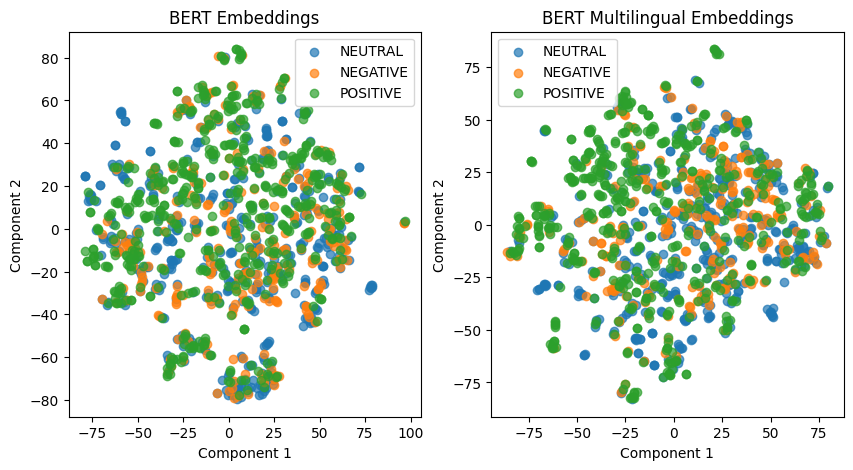

In [29]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Perform PCA on the embeddings
embeddings = np.load('bert_embeddings.npy')
embeddings_pt = np.load('bert_pt_embeddings.npy')
tsne = TSNE(n_components=2, perplexity=5)
embeddings_tsne = tsne.fit_transform(embeddings)
tsne_pt = TSNE(n_components=2, perplexity=5)
embeddings_tsne_pt = tsne_pt.fit_transform(embeddings_pt)

# Create a scatter plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for sentiment in df['real_sentiment'].unique():
    indices = df['real_sentiment'] == sentiment
    plt.scatter(embeddings_tsne[indices, 0], embeddings_tsne[indices, 1], label=sentiment, alpha=0.7)

plt.title("BERT Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()


plt.subplot(1, 2, 2)
for sentiment in df['real_sentiment'].unique():
    indices = df['real_sentiment'] == sentiment
    plt.scatter(embeddings_tsne_pt[indices, 0], embeddings_tsne_pt[indices, 1], label=sentiment, alpha=0.7)

plt.title("BERT Multilingual Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()


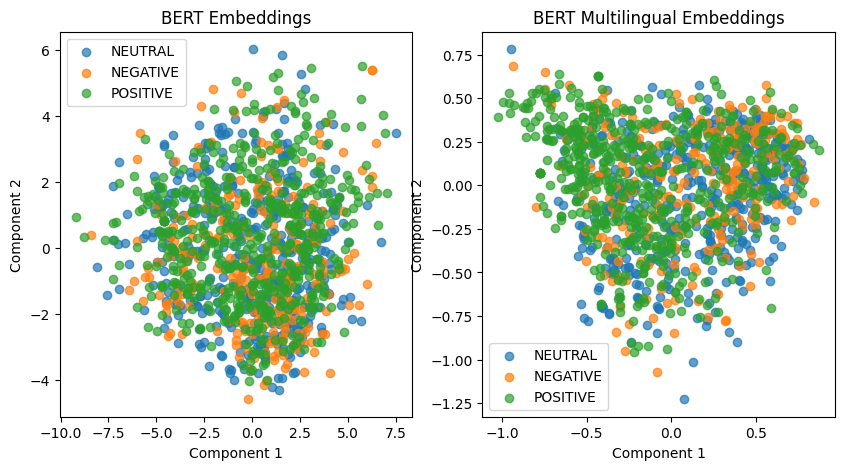

In [18]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Perform PCA on the embeddings
embeddings = np.load('bert_embeddings.npy')
embeddings_pt = np.load('bert_pt_embeddings.npy')
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)
pca_pt = PCA(n_components=2)
embeddings_pca_pt = pca_pt.fit_transform(embeddings_pt)

# Create a scatter plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for sentiment in df['real_sentiment'].unique():
    indices = df['real_sentiment'] == sentiment
    plt.scatter(embeddings_pca[indices, 0], embeddings_pca[indices, 1], label=sentiment, alpha=0.7)

plt.title("BERT Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()


plt.subplot(1, 2, 2)
for sentiment in df['real_sentiment'].unique():
    indices = df['real_sentiment'] == sentiment
    plt.scatter(embeddings_pca_pt[indices, 0], embeddings_pca_pt[indices, 1], label=sentiment, alpha=0.7)

plt.title("BERT Multilingual Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()


Verificando a acurácia dos dois modelos

In [21]:
embeddings = np.load('bert_embeddings.npy')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(embeddings, df['real_sentiment'], test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
acc_bert_ing = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_bert_ing:.4f}")

              precision    recall  f1-score   support

    NEGATIVE       0.35      0.32      0.34        53
     NEUTRAL       0.61      0.60      0.61        98
    POSITIVE       0.69      0.73      0.71       107

    accuracy                           0.60       258
   macro avg       0.55      0.55      0.55       258
weighted avg       0.59      0.60      0.59       258

Accuracy: 0.5969


[[0.32075472 0.43396226 0.24528302]
 [0.17346939 0.60204082 0.2244898 ]
 [0.13084112 0.14018692 0.72897196]]


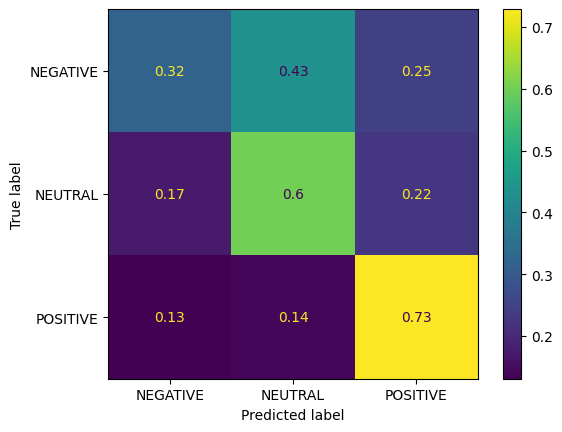

In [22]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

c = confusion_matrix(y_test, y_pred, normalize='true')
print(c)
_ = ConfusionMatrixDisplay(c, display_labels=clf.classes_).plot()

In [24]:
embeddings_pt = np.load('bert_pt_embeddings.npy')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(embeddings_pt, df['real_sentiment'], test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
acc_bert_multi = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_bert_multi:.4f}")

              precision    recall  f1-score   support

    NEGATIVE       0.41      0.21      0.28        53
     NEUTRAL       0.59      0.61      0.60        98
    POSITIVE       0.65      0.79      0.71       107

    accuracy                           0.60       258
   macro avg       0.55      0.53      0.53       258
weighted avg       0.58      0.60      0.58       258

Accuracy: 0.6008


[[0.20754717 0.45283019 0.33962264]
 [0.10204082 0.6122449  0.28571429]
 [0.05607477 0.1588785  0.78504673]]


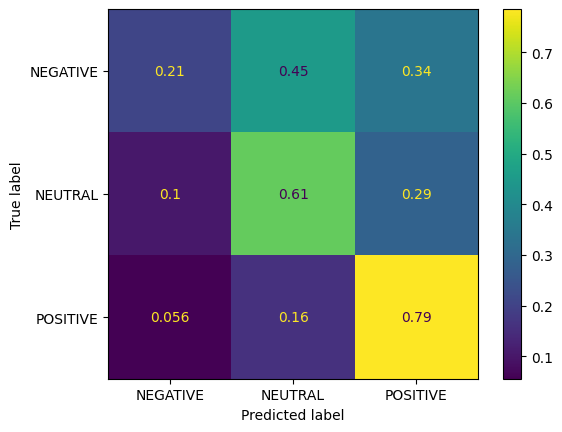

In [25]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

c = confusion_matrix(y_test, y_pred, normalize='true')
print(c)
_ = ConfusionMatrixDisplay(c, display_labels=clf.classes_).plot()

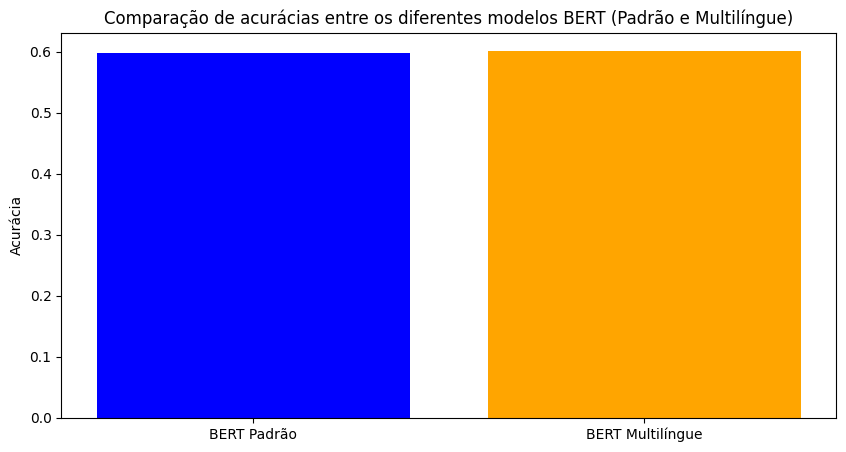

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(["BERT Padrão", "BERT Multilíngue"],[acc_bert_ing, acc_bert_multi], color=['blue', 'orange'])
plt.title("Comparação de acurácias entre os diferentes modelos BERT (Padrão e Multilíngue)")
plt.ylabel("Acurácia")
plt.show()

[[0.20754717 0.45283019 0.33962264]
 [0.10204082 0.6122449  0.28571429]
 [0.05607477 0.1588785  0.78504673]]


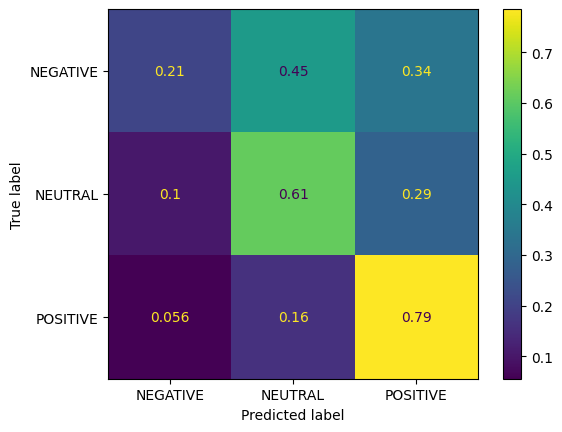

In [ ]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

c = confusion_matrix(y_test, y_pred, normalize='true')
print(c)
_ = ConfusionMatrixDisplay(c, display_labels=clf.classes_).plot()